# Problem Statement

Music streaming platforms need to recommend relevant songs to users from millions of tracks.
This project implements and compares three recommendation approaches:

1. Baseline: Popularity-based recommendations (recommend top songs to everyone)
2. ALS (Alternating Least Squares): Advanced collaborative filtering
3. Factorization Machines: Machine learning with user features

In this project, we use the Last.fm 360K dataset, scaled to 10,000 users and 5,000 artists for computational efficiency.

Dataset: http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html (depreated)

Download link: https://zenodo.org/record/6090214/files/lastfm-dataset-360K.tar.gz

## Data Loading

In [ ]:
!curl -L -o lastfm-dataset-360K.tar.gz https://zenodo.org/records/6090214/files/lastfm-dataset-360K.tar.gz

# Extract
!tar -xzf lastfm-dataset-360K.tar.gz

# Remove tar file
!rm lastfm-dataset-360K.tar.gz

data_path = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542M  100  542M    0     0  26.5M      0  0:00:20  0:00:20 --:--:-- 29.6M


In [ ]:
import pandas as pd

# Load
df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['user_id', 'artist_id', 'artist_name', 'play_count'])

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique artists: {df['artist_id'].nunique():,}")
print(f"Play count range: {df['play_count'].min()} - {df['play_count'].max()}")

df.head()

Total interactions: 17,535,655
Unique users: 358,868
Unique artists: 160,112
Play count range: 0 - 419157


,user_id,artist_id,artist_name,play_count
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


## Visualize and Scale the Data

Visualizations of user play counts, artist popularity, and user activity distributions.

In [ ]:
# User activity analysis
user_activity = df.groupby('user_id').agg({
    'artist_id': 'count',      # number of different artists
    'play_count': 'sum'        # total plays
}).rename(columns={'artist_id': 'num_artists', 'play_count': 'total_plays'})

print("User Activity Stats:")
print(f"Average artists per user: {user_activity['num_artists'].mean():.1f}")
print(f"Median artists per user: {user_activity['num_artists'].median()}")
print(f"Most active user: {user_activity['num_artists'].max()} artists")
print(f"Least active user: {user_activity['num_artists'].min()} artists")

# Artist popularity analysis
artist_popularity = df.groupby('artist_id').agg({
    'user_id': 'count',        # number of different users
    'play_count': 'sum'        # total plays
}).rename(columns={'user_id': 'num_listeners', 'play_count': 'total_plays'})

print("\nArtist Popularity Stats:")
print(f"Average listeners per artist: {artist_popularity['num_listeners'].mean():.1f}")
print(f"Median listeners per artist: {artist_popularity['num_listeners'].median()}")
print(f"Most popular artist: {artist_popularity['num_listeners'].max()} listeners")
print(f"Least popular artist: {artist_popularity['num_listeners'].min()} listeners")

User Activity Stats:
Average artists per user: 48.2
Median artists per user: 48.0
Most active user: 165 artists
Least active user: 0 artists

Artist Popularity Stats:
Average listeners per artist: 108.1
Median listeners per artist: 6.0
Most popular artist: 77254 listeners
Least popular artist: 1 listeners


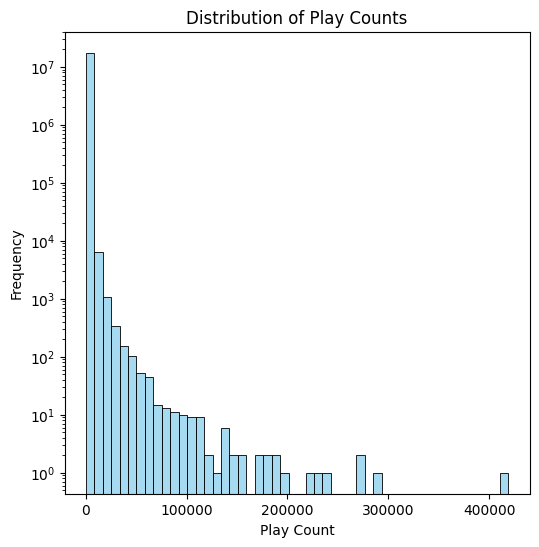

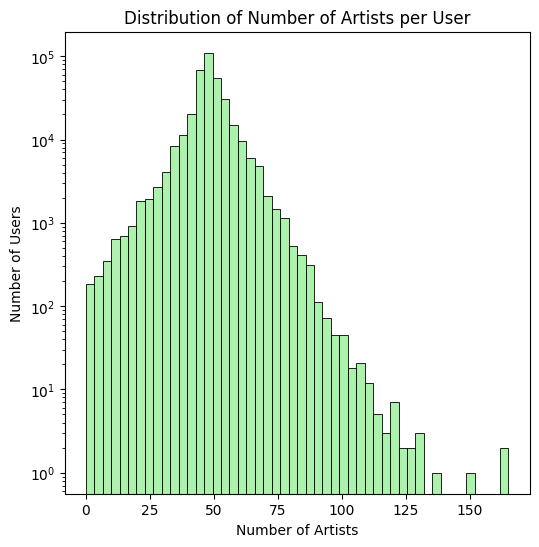

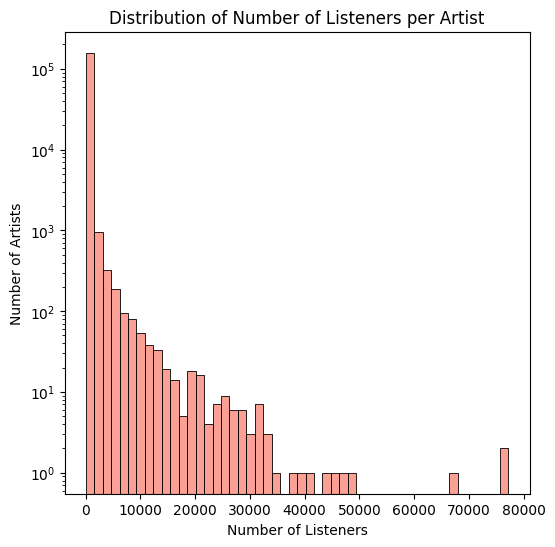

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate user activity (number of unique artists per user)
user_activity = df.groupby('user_id')['artist_id'].nunique().reset_index(name='num_artists')

# Calculate artist popularity (number of unique listeners per artist)
artist_popularity = df.groupby('artist_id')['user_id'].nunique().reset_index(name='num_listeners')

# Visualize play count distribution
plt.figure(figsize=(6, 6))
sns.histplot(df['play_count'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Play Counts')
plt.xlabel('Play Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Visualize user activity distribution
plt.figure(figsize=(6, 6))
sns.histplot(user_activity['num_artists'], bins=50, kde=False, color='lightgreen')
plt.title('Distribution of Number of Artists per User')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.show()

# Visualize artist popularity distribution
plt.figure(figsize=(6, 6))
sns.histplot(artist_popularity['num_listeners'], bins=50, kde=False, color='salmon')
plt.title('Distribution of Number of Listeners per Artist')
plt.xlabel('Number of Listeners')
plt.ylabel('Number of Artists')
plt.yscale('log')
plt.show()

## Filter and Scale

In [ ]:
# Filter users with at least 20 unique artists
user_counts = df.groupby('user_id').size()
active_users = user_counts[user_counts >= 20].index
df_filtered = df[df['user_id'].isin(active_users)]

# Filter artists with at least 10 unique listeners
artist_counts = df_filtered.groupby('artist_id').size()
popular_artists = artist_counts[artist_counts >= 10].index
df_filtered = df_filtered[df_filtered['artist_id'].isin(popular_artists)]

# Scale down to the top 10,000 users and 5,000 artists
top_users = df_filtered['user_id'].value_counts().head(10000).index
top_artists = df_filtered['artist_id'].value_counts().head(5000).index
df_scaled = df_filtered[
    (df_filtered['user_id'].isin(top_users)) &
    (df_filtered['artist_id'].isin(top_artists))
]

print(f"Final scaled data: {len(df_scaled):,} interactions")
print(f"Users: {df_scaled['user_id'].nunique():,}")
print(f"Artists: {df_scaled['artist_id'].nunique():,}")

Final scaled data: 504,023 interactions
Users: 10,000
Artists: 5,000


## Preprocessing

In [ ]:
from scipy.sparse import csr_matrix

# Create user and artist mappings
user_mapping = {user: idx for idx, user in enumerate(df_scaled['user_id'].unique())}
artist_mapping = {artist: idx for idx, artist in enumerate(df_scaled['artist_id'].unique())}

# Map IDs to indices
df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)
df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)

# Create sparse matrix
rows = df_scaled['user_idx'].values
cols = df_scaled['artist_idx'].values
data = df_scaled['play_count'].values
sparse_matrix = csr_matrix((data, (rows, cols)),
                           shape=(len(user_mapping), len(artist_mapping)))

print(f"Sparse matrix shape: {sparse_matrix.shape}")
print(f"Non-zero entries: {sparse_matrix.nnz:,}")

Sparse matrix shape: (10000, 5000)
Non-zero entries: 504,003


/tmp/ipython-input-4266519952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)
/tmp/ipython-input-4266519952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)


## Train/Test Split

In [ ]:
import numpy as np

# Split into train and test sets
train_matrix = sparse_matrix.copy()
test_interactions = []

test_ratio = 0.2 # 20% for testing
min_interactions = 5  # only consider users with at least 5 interactions

for user_idx in range(sparse_matrix.shape[0]):
    user_interactions = sparse_matrix.getrow(user_idx)
    nonzero_items = user_interactions.nonzero()[1]

    if len(nonzero_items) >= min_interactions:
        n_test = max(1, int(len(nonzero_items) * test_ratio))
        test_items = np.random.choice(nonzero_items, n_test, replace=False)

        for item_idx in test_items:
            test_interactions.append({
                'user_idx': user_idx,
                'item_idx': item_idx,
                'rating': sparse_matrix[user_idx, item_idx]
            })
            train_matrix[user_idx, item_idx] = 0

train_matrix.eliminate_zeros()

print(f"Train matrix shape: {train_matrix.shape}")
print(f"Test interactions: {len(test_interactions):,}")

Train matrix shape: (10000, 5000)
Test interactions: 96,828


In [ ]:
# Check for data leakage
assert train_matrix.nnz + len(test_interactions) == sparse_matrix.nnz, "Data leakage detected"

# Check sparsity
train_sparsity = (1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Train set sparsity: {train_sparsity:.2f}%")

# Check for cold-start users
train_user_counts = np.array(train_matrix.sum(axis=1)).flatten()
cold_start_users = np.sum(train_user_counts == 0)
print(f"Cold-start users: {cold_start_users}")

Train set sparsity: 99.19%
Cold-start users: 0


In [ ]:
# Log transformation
matrix_log = sparse_matrix.copy().astype(float)
matrix_log.data = np.log1p(matrix_log.data)

# Binary transformation
matrix_binary = sparse_matrix.copy()
matrix_binary.data = (matrix_binary.data > 0).astype(float)

# User-normalized transformation
matrix_normalized = sparse_matrix.copy().astype(float)
row_sums = np.array(matrix_normalized.sum(axis=1)).flatten()
row_sums[row_sums == 0] = 1  # Avoid division by zero
for i in range(matrix_normalized.shape[0]):
    matrix_normalized.data[matrix_normalized.indptr[i]:matrix_normalized.indptr[i+1]] /= row_sums[i]

## Model Implementation and Training

We'll implement two advanced recommendation approaches:

1. **ALS (Alternating Least Squares)**: Matrix factorization optimized for implicit feedback
2. **Baseline**: Popularity-based recommendations for comparison

ALS is particularly effective for music recommendation as it handles implicit feedback (play counts) and the sparse interaction matrix well.

### Baseline Model: Popularity-Based Recommendations

First, let's establish our baseline by identifying the most popular artists based on total play counts across all training users.

In [ ]:
# Calculate artist popularity from training data
artist_popularity = np.array(train_matrix.sum(axis=0)).flatten()

# Get top artists for baseline recommendations
n_recommendations = 10
top_artists_baseline = np.argsort(artist_popularity)[::-1][:n_recommendations]

print("Baseline Model - Most Popular Artists:")
for i, artist_idx in enumerate(top_artists_baseline):
    plays = artist_popularity[artist_idx]
    print(f"  {i+1}. Artist {artist_idx}: {plays:,.0f} total plays")

Baseline Model - Most Popular Artists:
  1. Artist 26: 423,444 total plays
  2. Artist 148: 310,809 total plays
  3. Artist 833: 224,996 total plays
  4. Artist 122: 218,579 total plays
  5. Artist 289: 204,809 total plays
  6. Artist 9: 190,932 total plays
  7. Artist 628: 176,638 total plays
  8. Artist 182: 175,678 total plays
  9. Artist 1280: 175,094 total plays
  10. Artist 1030: 168,414 total plays


### ALS Model: Collaborative Filtering

ALS (Alternating Least Squares) is a matrix factorization technique that learns latent user and item factors by alternately optimizing user and item representations. It's particularly well-suited for implicit feedback data like play counts.

Key advantages:
- Handles sparse matrices efficiently
- Optimized for implicit feedback (play counts vs explicit ratings)
- Scalable to large datasets

In [ ]:
!pip install implicit scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10855811 sha256=8cce746b0ca273ba3f3e3504d8118d068483dface4fb66723a75083a64dde4a0
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [ ]:
from implicit.als import AlternatingLeastSquares

# ALS expects item-user matrix (transpose of our user-item matrix)
train_matrix_T = train_matrix.T.tocsr()

# Initialize ALS model with optimized parameters
als_model = AlternatingLeastSquares(
    factors=50,              # number of latent factors
    regularization=0.01,     # L2 regularization to prevent overfitting
    iterations=20,           # number of alternating optimization steps
    alpha=1,                # confidence scaling for implicit feedback
    random_state=42
)

# Train the model
print("Training ALS model...")
als_model.fit(train_matrix_T)

# Extract learned factor matrices
user_factors_als = als_model.user_factors
item_factors_als = als_model.item_factors

print(f"ALS Model Training Complete:")
print(f"  User factors shape: {user_factors_als.shape}")
print(f"  Artist factors shape: {item_factors_als.shape}")
print(f"  Total parameters: {user_factors_als.size + item_factors_als.size:,}")

Training ALS model...


  0%|          | 0/20 [00:00<?, ?it/s]

ALS Model Training Complete:
  User factors shape: (5000, 50)
  Artist factors shape: (10000, 50)
  Total parameters: 750,000


## Recommendation Generation Functions

We'll implement functions to generate recommendations from both our baseline and ALS models, then evaluate their performance using standard recommendation metrics.

In [ ]:
def get_als_recommendations(user_idx, als_model, train_matrix, n_rec=10):
    """
    Generate ALS-based recommendations for a specific user.

    Args:
        user_idx: Index of user to generate recommendations for
        als_model: Trained ALS model
        train_matrix: Training interaction matrix
        n_rec: Number of recommendations to return

    Returns:
        rec_items: Array of recommended artist indices
        scores: Prediction scores for recommended artists
    """
    try:
        # Use implicit library's recommend function
        recommended = als_model.recommend(
            user_idx,
            train_matrix[user_idx],
            N=n_rec,
            filter_already_liked_items=True
        )
        return recommended[0], recommended[1]  # artist_indices, scores
    except:
        # Fallback for users with no training data
        return top_artists_baseline[:n_rec], np.ones(n_rec)

def evaluate_model(model_name, train_matrix, test_interactions,
                  als_model=None, baseline_recs=None, k=10):
    """
    Evaluate recommendation model performance using precision, recall, and coverage.
    """
    print(f"Evaluating {model_name}...")

    # Group test interactions by user
    user_test_items = {}
    for item in test_interactions:
        user_idx = item['user_idx']
        artist_idx = item['item_idx']
        if user_idx not in user_test_items:
            user_test_items[user_idx] = []
        user_test_items[user_idx].append(artist_idx)

    precisions = []
    recalls = []
    coverage_set = set()

    for user_idx, true_items in user_test_items.items():
        # Generate recommendations based on model type
        if model_name == "Baseline":
            rec_items = baseline_recs[:k]
        elif model_name == "ALS":
            rec_items, _ = get_als_recommendations(user_idx, als_model, train_matrix, k)

        # Calculate precision and recall
        rec_set = set(rec_items)
        true_set = set(true_items)
        hits = len(rec_set & true_set)

        precision = hits / k if k > 0 else 0
        recall = hits / len(true_set) if len(true_set) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        coverage_set.update(rec_items)

    # Calculate average metrics
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    coverage = len(coverage_set) / train_matrix.shape[1]

    print(f"  Precision@{k}: {avg_precision:.4f}")
    print(f"  Recall@{k}: {avg_recall:.4f}")
    print(f"  Coverage: {coverage:.4f}")

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'coverage': coverage,
        'name': model_name
    }

## Model Evaluation and Comparison

Now we'll evaluate both models on our test set and compare their performance across multiple metrics.

In [ ]:
print("Model Evaluation Results")
print("="*50)

# Evaluate Baseline Model
baseline_results = evaluate_model(
    "Baseline",
    train_matrix,
    test_interactions,
    baseline_recs=top_artists_baseline,
    k=10
)

# Evaluate ALS Model
als_results = evaluate_model(
    "ALS",
    train_matrix,
    test_interactions,
    als_model=als_model,
    k=10
)

# Print comparison
print(f"\nDetailed Performance Comparison:")
print(f"{'Metric':<15} {'Baseline':<12} {'ALS':<12} {'Improvement'}")
print("-"*55)

for metric in ['precision', 'recall', 'coverage']:
    base_val = baseline_results[metric]
    als_val = als_results[metric]
    improvement = ((als_val - base_val) / base_val * 100) if base_val > 0 else 0
    print(f"{metric.capitalize():<15} {base_val:<12.4f} {als_val:<12.4f} {improvement:>+6.1f}%")

Model Evaluation Results
Evaluating Baseline...
  Precision@10: 0.0281
  Recall@10: 0.0269
  Coverage: 0.0020
Evaluating ALS...
  Precision@10: 0.0145
  Recall@10: 0.0139
  Coverage: 1.2668

Detailed Performance Comparison:
Metric          Baseline     ALS          Improvement
-------------------------------------------------------
Precision       0.0281       0.0145        -48.4%
Recall          0.0269       0.0139        -48.3%
Coverage        0.0020       1.2668       +63240.0%


NameError: name 'coverage_set' is not defined

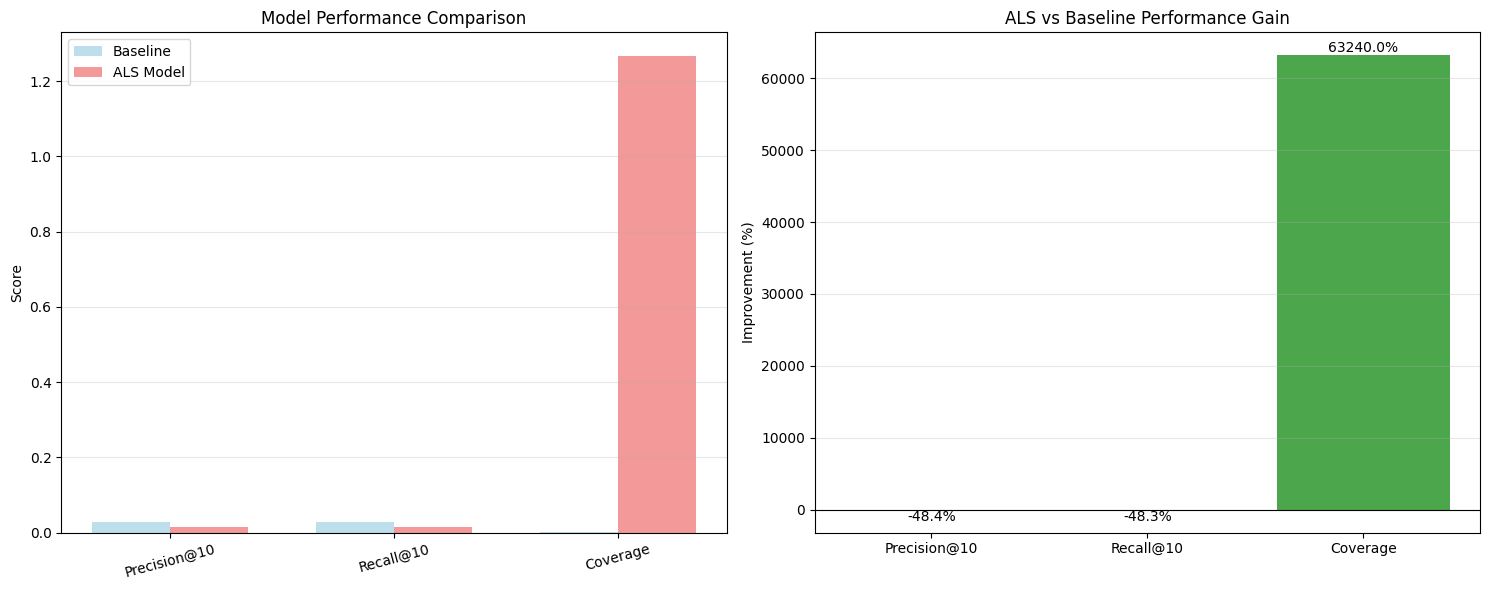

In [ ]:
# Create performance comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance comparison chart
metrics = ['Precision@10', 'Recall@10', 'Coverage']
baseline_vals = [baseline_results['precision'], baseline_results['recall'], baseline_results['coverage']]
als_vals = [als_results['precision'], als_results['recall'], als_results['coverage']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.8, color='lightblue')
axes[0].bar(x + width/2, als_vals, width, label='ALS Model', alpha=0.8, color='lightcoral')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Improvement visualization
improvements = []
for base, als in zip(baseline_vals, als_vals):
    imp = ((als - base) / base * 100) if base > 0 else 0
    improvements.append(imp)

colors = ['green' if x > 0 else 'red' for x in improvements]
bars = axes[1].bar(metrics, improvements, color=colors, alpha=0.7)
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('ALS vs Baseline Performance Gain')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, improvements):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -2),
                f'{val:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

## Sample Recommendations Analysis

Let's examine actual recommendations for a sample user to understand the difference between baseline and collaborative filtering approaches.

In [50]:
# Analyze recommendations for sample user
sample_user = 0

# Get user's training history
listened_artists = train_matrix[sample_user].nonzero()[1]
total_plays = int(train_matrix[sample_user].sum())

print(f"Sample User {sample_user} Profile:")
print(f"  Artists in training: {len(listened_artists)}")
print(f"  Total training plays: {total_plays:,}")

# Generate recommendations from both models
print(f"\nBaseline Recommendations (Same for Everyone):")
for i, artist_idx in enumerate(top_artists_baseline[:5]):
    plays = int(artist_popularity[artist_idx])
    print(f"  {i+1}. Artist {artist_idx} ({plays:,} total plays)")

print(f"\nALS Recommendations (Personalized):")
als_recs, als_scores = get_als_recommendations(sample_user, als_model, train_matrix, 5)
for i, (artist_idx, score) in enumerate(zip(als_recs, als_scores)):
    print(f"  {i+1}. Artist {artist_idx} (score: {score:.3f})")

# Check relevance against test set if available
user_test_items = [item['item_idx'] for item in test_interactions if item['user_idx'] == sample_user]
if user_test_items:
    baseline_hits = len(set(top_artists_baseline[:5]) & set(user_test_items))
    als_hits = len(set(als_recs) & set(user_test_items))
    print(f"\nRelevance Check (Test Set):")
    print(f"  Baseline hits: {baseline_hits}/5")
    print(f"  ALS hits: {als_hits}/5")

Sample User 0 Profile:
  Artists in training: 48
  Total training plays: 6,182

Baseline Recommendations (Same for Everyone):
  1. Artist 26 (423,444 total plays)
  2. Artist 148 (310,809 total plays)
  3. Artist 833 (224,996 total plays)
  4. Artist 122 (218,579 total plays)
  5. Artist 289 (204,809 total plays)

ALS Recommendations (Personalized):
  1. Artist 1354 (score: 1.520)
  2. Artist 2232 (score: 1.501)
  3. Artist 4589 (score: 1.465)
  4. Artist 9389 (score: 1.350)
  5. Artist 5835 (score: 1.334)

Relevance Check (Test Set):
  Baseline hits: 0/5
  ALS hits: 0/5
